The purpose of this capstone is to accurately predict the quantity of phycocyanin and identify the most important predictors of water quality metrics for making these estimates. In other words, the main goal is to predict the “phycocyanin” column with the explanatory variables and then perform feature importance.

# 1. Data Wrangling

In [1]:
# Libraries imported for this notebook.

import pandas as pd
import matplotlib.pyplot as plt

## Data Acquisition

AquaRealTime provided a login to their data portal from which I downloaded Lake Fictitious data.

In [2]:
# Read Lake_Fictitious_AquaRealTime_Data_Orig into a dataframe, formatted dates, and indexed dates.

df_orig = pd.read_csv('Lake_Fictitious_AquaRealTime_Data_Orig.csv', parse_dates=True, index_col=[1])

In [3]:
# Viewed dataframe.

df_orig

,Unnamed: 0,utcTime,light,airTemp,waterTemp,turbidity,phycocyanin,chlorA,waterLight,buoyTemp,battVolts,battSOC,sigStrength,sigQuality,codeVersion,panelVolts,leakDetect,phycocyaninTrend,chlorATrend,turbidityTrend
timeString,,,,,,,,,,,,,,,,,,,,
2022-04-22 17:26:24,NaN,1650662784,0.000000,-1.000000,0.000000,0.00,0.000000,0.000000,74,0.000000,4.1,100.000000,84.998856,0,220319,17.799999,9,0.000,0.000,0.000
2022-04-25 18:58:08,NaN,1650927488,12.800000,1051.823120,23.100000,400.00,1051.819946,2686.370117,54,25.200001,4.1,100.000000,91.665527,0,220319,4.700000,7,10.518,134.319,4.000
2022-05-25 13:08:16,NaN,1653498496,1774.699951,-7.751092,21.500000,12.14,0.000000,0.000000,12,23.799999,4.0,96.699997,57.499046,1,220319,20.400000,3,10.414,127.635,4.083
2022-05-25 13:38:08,NaN,1653500288,2500.000000,-7.751092,21.600000,12.14,0.000000,0.000000,12,24.000000,4.0,96.699997,57.499046,1,220319,20.600000,4,10.330,122.253,4.341
2022-05-25 14:08:00,NaN,1653502080,619.099976,-9.301310,22.000000,11.08,0.000000,0.000000,12,24.600000,4.0,96.699997,57.499046,1,220319,18.600000,4,10.247,117.140,4.658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20 18:34:24,NaN,1708472064,12.800000,1793.138794,24.900000,400.00,1793.130005,2785.780029,271,23.500000,4.1,100.000000,11.110094,85,240217,0.000000,9,793.099,2610.042,172.826
2024-02-20 19:00:00,NaN,1708473600,11.700000,1805.576660,24.600000,400.00,1805.569946,2785.780029,30,23.299999,4.1,100.000000,11.110094,84,240217,0.000000,7,803.225,2618.861,175.099
2024-02-20 19:29:52,NaN,1708475392,7.200000,1818.014648,24.299999,400.00,1818.010010,2787.750000,30,22.700001,4.1,100.000000,11.110094,84,240217,0.000000,11,813.374,2627.335,177.349


Data looked in very good condition. Little cleaning to be done. I can see right away that the first column and the first two rows should be removed based on the timestamp and data. The unit was most likely turned on for an hour but not placed in Lake Ficticious.

In [4]:
# Removed rows and columns.

# Remove the first two rows
df = df_orig.iloc[2:]

# Remove the second column
df = df.iloc[:, 1:]

In [5]:
# Confirmed removal.

df.head(5)

,utcTime,light,airTemp,waterTemp,turbidity,phycocyanin,chlorA,waterLight,buoyTemp,battVolts,battSOC,sigStrength,sigQuality,codeVersion,panelVolts,leakDetect,phycocyaninTrend,chlorATrend,turbidityTrend
timeString,,,,,,,,,,,,,,,,,,,
2022-05-25 13:08:16,1653498496,1774.699951,-7.751092,21.500000,12.14,0.0,0.0,12,23.799999,4.0,96.699997,57.499046,1,220319,20.400000,3,10.414,127.635,4.083
2022-05-25 13:38:08,1653500288,2500.000000,-7.751092,21.600000,12.14,0.0,0.0,12,24.000000,4.0,96.699997,57.499046,1,220319,20.600000,4,10.330,122.253,4.341
2022-05-25 14:08:00,1653502080,619.099976,-9.301310,22.000000,11.08,0.0,0.0,12,24.600000,4.0,96.699997,57.499046,1,220319,18.600000,4,10.247,117.140,4.658
2022-05-25 14:37:52,1653503872,1189.599976,-8.526201,21.799999,10.01,0.0,0.0,12,24.200001,4.0,96.500000,57.499046,1,220319,20.400000,2,10.164,112.283,4.774
2022-05-25 15:01:20,1653505280,513.200012,-7.751092,21.799999,9.16,0.0,0.0,11,24.000000,4.0,96.500000,60.000004,1,220319,19.700001,2,10.083,107.669,4.936


In [6]:
# Explored dimensions.

df.shape

(19195, 19)

Confirmed that I had sufficient rows of data to create regression models.

## Data Cleaning

### Duplicate Rows

In [7]:
# Checked for duplicate rows

duplicate_rows = df.duplicated(keep=False)
df[duplicate_rows]

,utcTime,light,airTemp,waterTemp,turbidity,phycocyanin,chlorA,waterLight,buoyTemp,battVolts,battSOC,sigStrength,sigQuality,codeVersion,panelVolts,leakDetect,phycocyaninTrend,chlorATrend,turbidityTrend
timeString,,,,,,,,,,,,,,,,,,,


### Columns

No duplicate rows.

In [8]:
# Removed unneeded columns.

df = df[['light', 'airTemp', 'waterTemp', 'turbidity', 'phycocyanin', 'chlorA', 'waterLight']].copy()

### Missing data

In [9]:
# Explored data.

index_dtype = df.index.dtype
print("Index Data Type:", index_dtype)
print()
df.info()

Index Data Type: datetime64[ns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19195 entries, 2022-05-25 13:08:16 to 2024-02-20 20:27:28
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   light        19195 non-null  float64
 1   airTemp      19195 non-null  float64
 2   waterTemp    19195 non-null  float64
 3   turbidity    19195 non-null  float64
 4   phycocyanin  19195 non-null  float64
 5   chlorA       19195 non-null  float64
 6   waterLight   19195 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 1.2 MB


No missing data and all data is in the correct dtype. Although, this does not identify rows that are missing entirely.

In [10]:
# Checked for missing rows.

# Rounded times to the nearest half hour
df.index = df.index.round('30min')

# Calulated difference in time between rows
time_diff = df.index.to_series().diff()

# Convert nanoseconds to half hours
time_diff_hours = time_diff / (1.8 * 10**12)

# Printed all the unique values of the calculated time difference
time_diff_hours = time_diff_hours[1:] # Exclude the first row becasue a difference cannot be calculates.
print("Data gaps with number of missing rows:")
print(time_diff_hours.unique())

Data gaps with number of missing rows:
[   1    0    2    5   53    9   33   -1 6394    6 1093 3711]


The data has gaps in which the unit must not have been working or was turned off. This may or may not be an issue depending on which machine learning models I choose.

### Values

In [11]:
# Printed summary statistics.
df.describe()

,light,airTemp,waterTemp,turbidity,phycocyanin,chlorA,waterLight
count,19195.000000,19195.000000,19195.000000,19195.000000,19195.000000,19195.000000,19195.000000
mean,212.577098,135.695843,19.536895,53.060269,139.455234,343.709971,37.902370
std,338.756920,349.402586,7.117741,125.397086,349.891177,751.441266,63.786091
min,0.000000,-71.310043,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,3.349345,14.000000,3.850000,3.920000,30.549999,11.000000
50%,5.100000,16.526201,21.500000,5.400000,13.210000,71.070000,13.000000
75%,336.300003,29.474453,25.299999,14.520000,29.469999,136.220001,30.000000
max,2500.000000,1935.138794,44.400002,400.000000,1935.130005,3000.000000,326.000000


Observations from this description.  

light - All values are possible.  
airTemp - The values are suspect or not possible. I will check this when I plot the data but I imagine this column will be removed.  
waterTemp - A min of zero is possabe as long as it occurs i na winter month. A max of 44 is unlikely. I will check this when I plot the data.  
turbidity - All values are possible.  
phycocyanin - All values are possible.  
chlorA - All values are possible.  
waterLight - A value of -1 is not possible. I will check this when I plot the data.

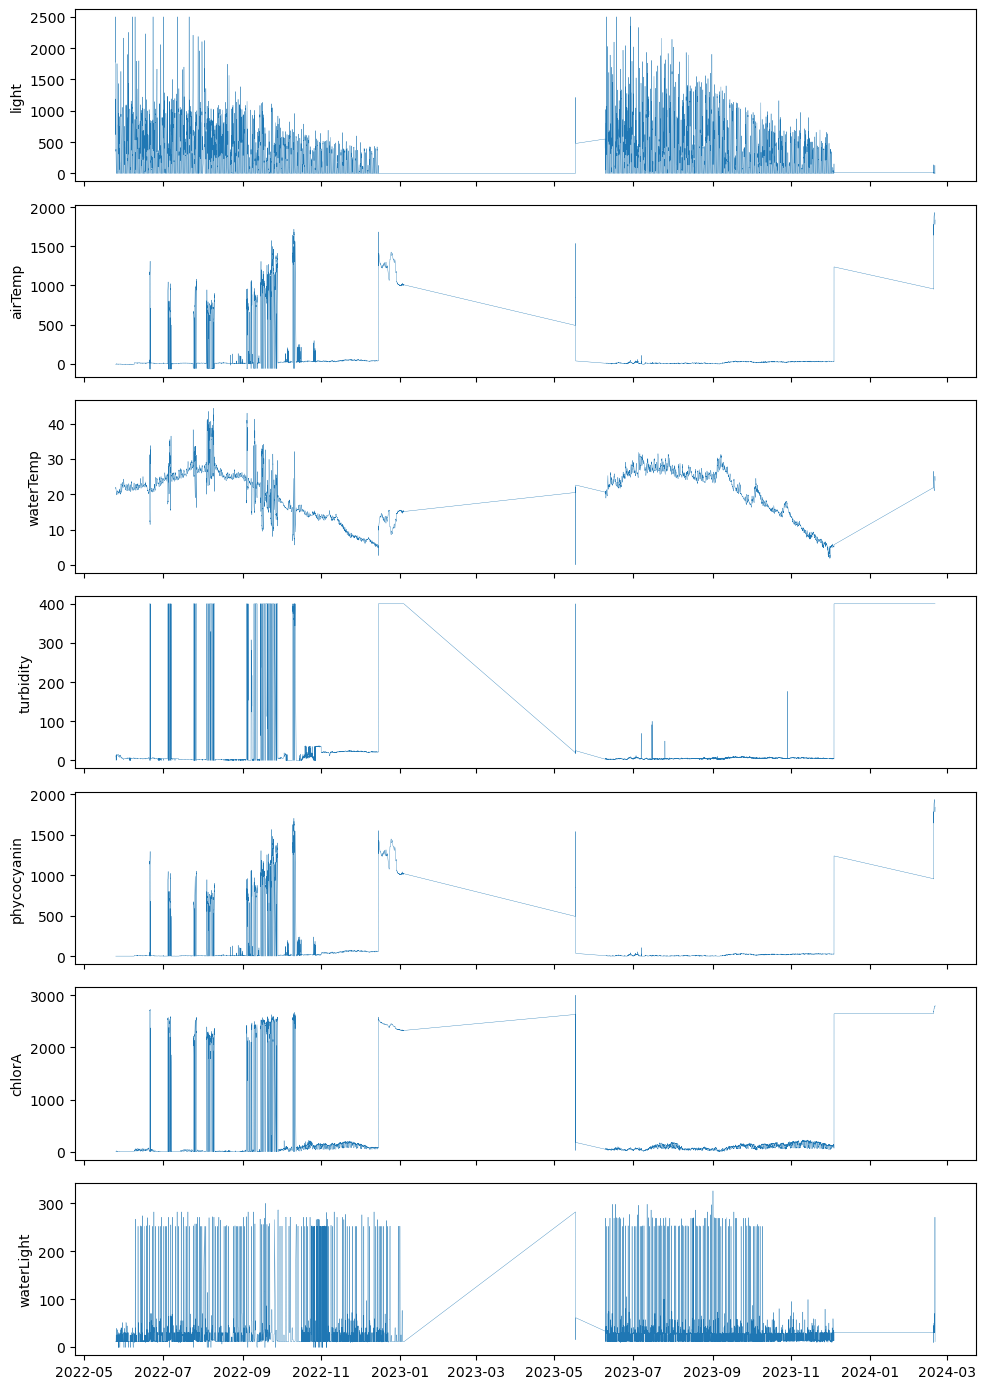

In [12]:
# Plotted data.

fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 2 * len(df.columns)), sharex=True)
for i, column in enumerate(df.columns):
    axes[i].plot(df.index, df[column], linewidth=0.25)
    axes[i].set_ylabel(column)
plt.tight_layout()
plt.show()

# Data save

In [ ]:
# Saved dataframe.
df.to_excel('Lake_Fictitious_AquaRealTime_Data_Cleaned.xlsx', index=True)